# Import packages

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
sys.path.append("..")
from utils import *

# Helpers functions

In [2]:
# Helper functions

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

# Load images

In [3]:
root_dir = "../../data/training/"

image_dir = root_dir + "images/"

files = os.listdir(image_dir)
n = min(20, len(files)) #load max 5 images

print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
n_train = 3 #use 3 images for training

Loading 20 images
Loading 20 images


# Info

Image size = 400,400


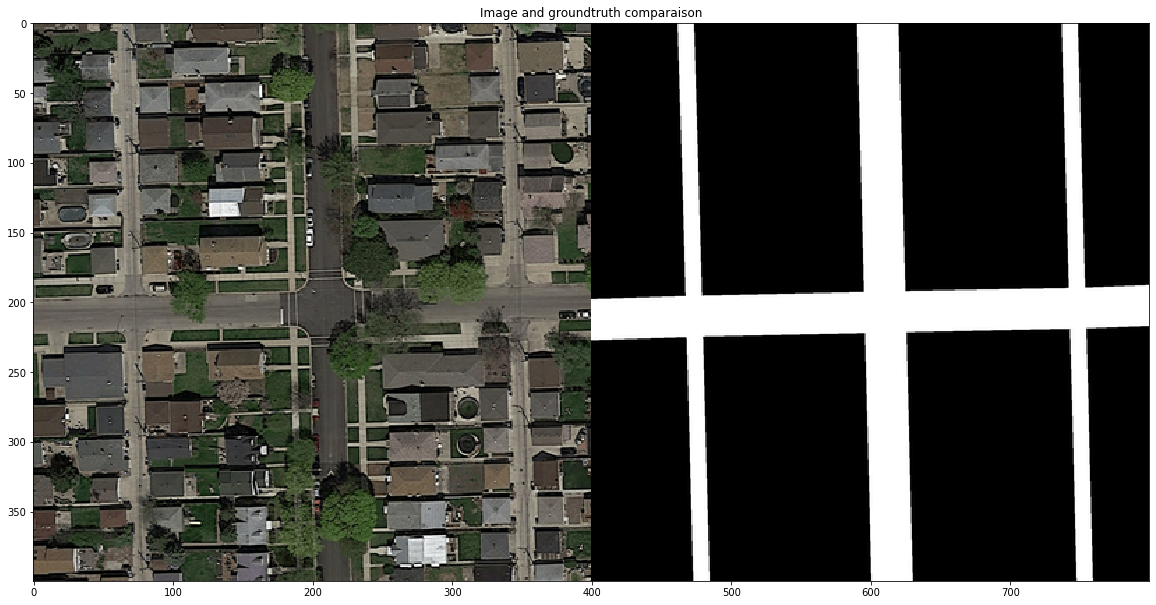

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))
# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(20, 20))
plt.title('Image and groundtruth comparaison')
plt.imshow(cimg, cmap='Greys_r')

# Shows patches

(12500, 16, 16, 3)


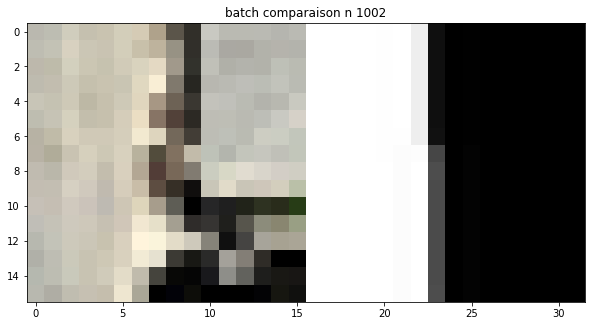

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])


fign = plt.figure(figsize=(10,10))
print(img_patches.shape)
image_number=1002
cimg = concatenate_images(img_patches[image_number], gt_patches[image_number])
plt.title('batch comparaison n 1002')
plt.imshow(cimg)


# Gaussian Blur

<Figure size 720x720 with 0 Axes>

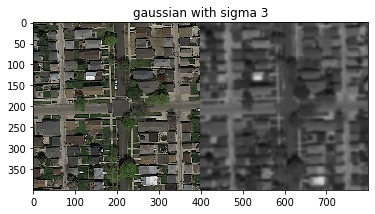

In [6]:
#Apply gaussian blur to images
from scipy.ndimage import gaussian_filter
def convert_gaussian(_sigma, img):
    _sigma = 3
    gauss_img = gaussian_filter(img, sigma=_sigma)
    return gauss_img

fig_gauss = plt.figure(figsize=(10,10))
gauss_img = convert_gaussian(3, imgs[0])
cimg = concatenate_images(imgs[0], gauss_img)
plt.figure()
plt.title('gaussian with sigma 3')
plt.imshow(cimg)

# 2D FFT useless

(400, 400)


Text(0.5, 1.0, 'Filtered Spectrum')

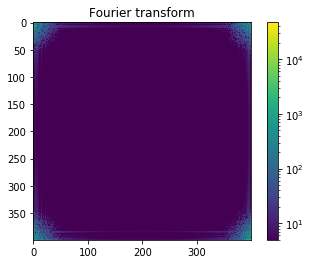

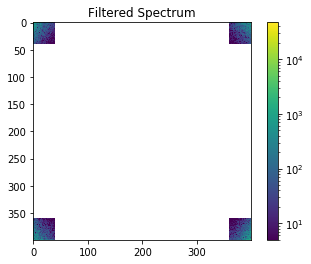

In [7]:
from scipy import fftpack
from skimage import color
gauss_img_gray = color.rgb2gray(gauss_img)
im_fft = fftpack.fft2(gauss_img_gray)
print(gauss_img_gray.shape)
# Show the results

def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(im_fft)
plt.title('Fourier transform')



# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.1

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
im_fft2 = im_fft.copy()

# Set r and c to be the number of rows and columns of the array.
r, c = im_fft2.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

plt.figure()
plot_spectrum(im_fft2)
plt.title('Filtered Spectrum')

Text(0.5, 1.0, 'Reconstructed Image')

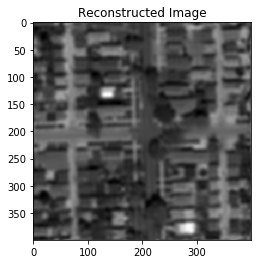

In [8]:
# Reconstruct the denoised image from the filtered spectrum, keep only the
# real part for display.
im_new = fftpack.ifft2(im_fft2).real

plt.figure()
plt.imshow(im_new, plt.cm.gray)
plt.title('Reconstructed Image')

# Hough transform

NameError: name 'edges' is not defined

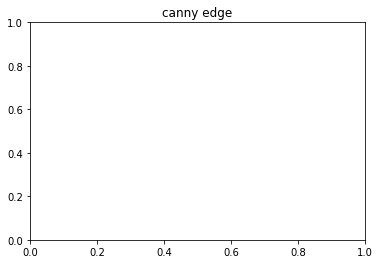

In [9]:
import cv2
img = imgs[0]
img = (img*255).astype(np.uint8)#convert to smth opencv can work with


gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#edges = cv2.Canny(img,10,20,apertureSize = 3)

##autocanny
v = np.median(img)
sigma = 0.33
# apply automatic Canny edge detection using the computed median
lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edged = cv2.Canny(img, lower, upper)
##end autocanny

plt.figure()
plt.title('canny edge')
plt.imshow(edges)

lines = cv2.HoughLines(edges, 1, np.pi / 180, 250, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


plt.figure(figsize=(10,10))
plt.imshow(img)

# Probabilistic Hough Transform

In [ ]:
import cv2
img_number = 12
aperture_original = 3
aperture_gaussian = 5


img_analyse = imgs[img_number]
img_analyse = (img_analyse*255).astype(np.uint8)#convert to smth opencv can work with
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,15))
plt.title('Hough transform test 2')

###############################################
###############################################
axs[0, 0].imshow(img_analyse)
axs[0, 0].set_title('original image')

#CANNY ORIGINAL

edges = cv2.Canny(img_analyse,400,400,apertureSize = aperture_original)
axs[0,1].imshow(edges)
axs[0,1].set_title('ori canny')

#HOUGH ORIGINAL
minLineLength = 50
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180,1,minLineLength,maxLineGap)
for _line in lines:
    for x1, y1, x2, y2 in _line:
        cv2.line(img_analyse,(x1, y1), (x2, y2),(0,255,0),2)
axs[0,2].imshow(img_analyse)
axs[0,2].set_title('probabilistic Hough')

###############################################
###############################################


#GAUSS
img_analyse = imgs[img_number]
img_analyse = (img_analyse*255).astype(np.uint8)#convert to smth opencv can work with

gauss_img = convert_gaussian(2, img_analyse)
axs[1, 0].imshow(gauss_img)
axs[1, 0].set_title('gaussian image')


#CANNY Gauss
gray_gauss_img = cv2.cvtColor(gauss_img, cv2.COLOR_BGR2GRAY)

gray_gauss_img = (gray_gauss_img*255).astype(np.uint8)#need to convert to 0-255 in order to not lose information
edges_gauss = cv2.Canny(gray_gauss_img, 400, 400, apertureSize=aperture_gaussian)
axs[1,1].imshow(edges_gauss)
axs[1,1].set_title('canny gauss')

#HOUGH Gauss
minLineLength = 10
maxLineGap = 2
##HoughLineP(image,rho, theta, threshold, np.array ([ ]), minLineLength=xx, maxLineGap=xx)
lines = cv2.HoughLinesP(edges_gauss,1,np.pi/180,20,minLineLength,maxLineGap)
for _line in lines:
    for x1, y1, x2, y2 in _line:
        cv2.line(img_analyse,(x1, y1), (x2, y2),(0,255,0),2)
axs[1,2].imshow(img_analyse)
axs[1,2].set_title('probabilistic Hough')

###############################################
###############################################

# Another try

In [ ]:
import cv2
import numpy as np
image_number = 0
kernel_size = 5

img_in = imgs[image_number]
img_in = (img_in*255).astype(np.uint8)#convert to smth opencv can work with




gray = cv2.cvtColor(img_in,cv2.COLOR_BGR2GRAY)
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 70  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img_in) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)
print(lines)
points = []
for line in lines:
    for x1, y1, x2, y2 in line:
        points.append(((x1 + 0.0, y1 + 0.0), (x2 + 0.0, y2 + 0.0)))
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(img_in, 0.8, line_image, 1, 0)
print(lines_edges.shape)
#cv2.imwrite('line_parking.png', lines_edges)
plt.figure(figsize=(15,15))
plt.imshow(lines_edges)

# Colors

In [ ]:
# import the necessary packages
import scipy.spatial as sp
import matplotlib.pyplot as plt
import cv2

#Stored all RGB values of main colors in a array
main_colors = [(0,0,0),
                  (255,255,255),
                  (255,0,0),
                  (0,255,0),
                  (0,0,255),
                  (255,255,0),
                  (0,255,255),
                  (255,0,255),
                  ] 

image = imgs[0]
plt.figure()
#convert BGR to RGB image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

h,w,bpp = np.shape(image)

#Change colors of each pixel
#reference :https://stackoverflow.com/a/48884514/9799700
for py in range(0,h):
    for px in range(0,w):
      ########################
      #Used this part to find nearest color 
      #reference : https://stackoverflow.com/a/22478139/9799700
      input_color = (image[py][px][0],image[py][px][1],image[py][px][2])
      tree = sp.KDTree(main_colors) 
      ditsance, result = tree.query(input_color) 
      nearest_color = main_colors[result]
      ###################
      
      image[py][px][0]=nearest_color[0]
      image[py][px][1]=nearest_color[1]
      image[py][px][2]=nearest_color[2]

# show image
plt.figure()
plt.axis("off")
plt.imshow(image)